# spaCy/HDBScan Feature Extraction Pipeline

### Note: it can be quite complicated to install spaCy and sense2vec, given conflicting low-level requirementso, so at this point I wouldn't suggest that others try to install the libraries and run this notebook.
  
However, it is well worth scanning down to the cell titled ***Harvesting Word Features***. In the output of that cell, there are examples of 52 feature clusters harvested by this process. The ultimate output of this process will produce a dataset containing a product ID (asin), overall rating, and word feature, for each word feature found in each product review. I don't consider these feature clusters as the final product, and we should discuss.


### We can use this output for several purposes. 

1. First, we should be able to quite easily make the data available to th web interface, so that we can display the top n word features (by overall rating) associated with products returned.

2. We will want to also include the user's selected word features in our model evaluation, to enable them to "drill into" selected features and thus explore the product/feature landscape.

3. Finally, I think it would be worth training a model on a vectorized representation of the top n most highly rated features, which may give us another dimension for predicting rating based on feature combination/interaction.

In [1]:
#!conda uninstall -y spacy

#Installing spaCy :

# For Linux:
# !conda install -y spacy -c conda-forge
# (use "spacy[cuda100]", if you have the 10.0 cuda driver installed) 

# For Mac:
# !pip install spacy==2.0.7

# Installing HDBScan and sense2vec
# !conda install -y -c conda-forge hdbscan
# !pip install sense2vec==1.1.1a0

In [2]:
#!pip install matplotlib
#!python -m pip list

In [3]:
import pandas as pd
import gzip
import time
# Install a few python packages using pip
from common import utils
utils.require_package("wget")      # for fetching dataset

In [4]:
# Standard python helper libraries.
from __future__ import print_function
from __future__ import division
import os, sys, time
import collections
import itertools

# Numerical manipulation libraries.
import numpy as np

#Visualization
import matplotlib
%matplotlib inline

import spacy
#activated = spacy.prefer_gpu()

In [5]:
def parse(path):
  print('start parse')
  start_parse = time.time()
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
  end_parse = time.time()
  print('end parse with time for parse',end_parse - start_parse)

def getDF(path):
  print('start getDF')
  start = time.time()
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  print('end getDF')
  end = time.time()
  print('time taken to load data = ',end-start)
  return pd.DataFrame.from_dict(df, orient='index')

start = time.time()
print("Reading Pandas dataframe from reviews_Toys_and_Games_5.json.gz...")
df = getDF('./data/reviews_Toys_and_Games_5.json.gz')
print("...read reviews_Toys_and_Games_5.json.gz in {} seconds.".format(time.time()-start))

Reading Pandas dataframe from reviews_Toys_and_Games_5.json.gz...
start getDF
start parse
end parse with time for parse 9.116703510284424
end getDF
time taken to load data =  9.117938995361328
...read reviews_Toys_and_Games_5.json.gz in 11.589332580566406 seconds.


In [6]:
print(df.shape)
print(df.columns)
df.head(2)

(167597, 9)
Index(['reviewerID', 'overall', 'unixReviewTime', 'asin', 'reviewTime',
       'reviewText', 'summary', 'helpful', 'reviewerName'],
      dtype='object')


,reviewerID,overall,unixReviewTime,asin,reviewTime,reviewText,summary,helpful,reviewerName
0,A1VXOAVRGKGEAK,5.0,1390953600,0439893577,"01 29, 2014",I like the item pricing. My granddaughter want...,Magnetic board,"[0, 0]",Angie
1,A8R62G708TSCM,4.0,1395964800,0439893577,"03 28, 2014",Love the magnet easel... great for moving to d...,it works pretty good for moving to different a...,"[1, 1]",Candace


In [7]:
start = time.time()
print("Collecting summary counts of reviews by rating...")
print(df.groupby('overall').count())
print("...completed counts by rating in {} seconds.".format(time.time()-start))

         reviewerID  unixReviewTime    asin  reviewTime  reviewText  summary  \
overall                                                                        
1.0            4707            4707    4707        4707        4707     4707   
2.0            6298            6298    6298        6298        6298     6298   
3.0           16357           16357   16357       16357       16357    16357   
4.0           37445           37445   37445       37445       37445    37445   
5.0          102790          102790  102790      102790      102790   102790   

         helpful  reviewerName  
overall                         
1.0         4707          4693  
2.0         6298          6279  
3.0        16357         16299  
4.0        37445         37292  
5.0       102790        102196  
...completed counts by rating in 0.15585589408874512 seconds.


In [8]:
import hdbscan
import seaborn as sns
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
from spacy.tokens import Doc



from sense2vec import Sense2VecComponent

start = time.time()
print("Reading English core web medium language data using spaCy...")
nlp = spacy.load('en_core_web_md')
print("...finished reading English core web medium language data in {} seconds.".format(time.time()-start))

#nlp_plain = spacy.load('en_core_web_md')
print("spaCy loaded en_core_web_md")
s2v = Sense2VecComponent('/home/burgew/w210_data/reddit_vectors-1.1.0')

IGNORED_LEMMAS = ['-PRON-']
IGNORED_POS = ['PUNCT', 'SPACE', 'PART', 'DET']

print("nlp: {}".format(nlp))
last_nlp_component = nlp.pipeline[-1]
if last_nlp_component[0] != 'sense2vec':
    nlp.add_pipe(s2v)
    print("added sense2vec to spaCy NLP pipeline")
else:
    print("sense2vec previously added to spaCy NLP pipeline")


Reading English core web medium language data using spaCy...
...finished reading English core web medium language data in 17.705079793930054 seconds.
spaCy loaded en_core_web_md
nlp: <spacy.lang.en.English object at 0x7fd4f43ef7f0>
added sense2vec to spaCy NLP pipeline


In [9]:
print("nlp.pipeline[{}]: {}".format(len(nlp.pipeline), nlp.pipeline))

nlp.pipeline[4]: [('tagger', <spacy.pipeline.Tagger object at 0x7fd4f4414a90>), ('parser', <spacy.pipeline.DependencyParser object at 0x7fd4f2ed60f8>), ('ner', <spacy.pipeline.EntityRecognizer object at 0x7fd4f2ed6150>), ('sense2vec', <sense2vec.Sense2VecComponent object at 0x7fd4f4a7cf98>)]


In [71]:

debug = False

lemmas = {}
ignore_words = []

def consume_suspect_tokens(text, nlp, ignore_words, lemmas, ignore_initial=False):
    """ Parse text and return ignored words at the begining of the phrase, along with the valid phrase (if any)
    at the end of the phrase token.
    
    Args
    ----------
    ignore_initial (boolean) indicator of whether to ignore the first word in the phrase token (when a recursive call)
    text (string)            text to be parsed, tokenized, and vectorized
    nlp (spaCy pipeline)     pipeline to use for processing the input text
    ignore_words (list)      collected set of words to be ignored, to which this function may add words
    lemmas (dict)            dict of word->
    
    Returns:
    ----------
    None
    """
    if ignore_initial:
        token_parts = text.split(" ")
        first_word = token_parts[0]
        
        if first_word not in ignore_words:
            ignore_words.append(first_word)
            print("Ignoring word '{}' in feature extraction...".format(first_word))    
        
        if (" " in text) and (len(text.split(" "))>1):
            text = " ".join(token_parts[1:])
        else:
            return None

    doc = nlp(text)
    
    for token in doc:
        if debug:
            print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop, [child for child in token.children])
        lower_token = token.text.lower()
        if (lower_token is not None):
            if (lower_token not in ignore_words):
                if (token.lemma_ in IGNORED_LEMMAS) or (token.pos_ in IGNORED_POS):
                    consume_suspect_tokens(text, nlp, ignore_words, lemmas, ignore_initial=True)
                else:
                    lemmas[token.text] = lower_token
                
        return None


def get_vectors(text, nlp, ignore_words, lemmas):
    """ <generator> Get embedding word vectors from a given text object. 
    Args
    ----------
    text (string)            text to be parsed, tokenized, and vectorized
    nlp (spaCy pipeline)     pipeline to use for processing the input text
    ignore_words (list)      collected set of words to be ignored, to which this function may add words
    lemmas (dict)            dict of word->
    
    Generates:
    ----------
    processed text (string) 
    phrase vector (numpy.ndarray)
    """
    
    chunks_seen = []
    consume_suspect_tokens(text, nlp, ignore_words, lemmas)
              
    doc = nlp(text)
    #####
    # Next, iterate through the sentences and within those the noun chunks.
    # These noun chunks will be lemmatized and collected as potential features.
    #####
    for sent in doc.sents:
        for chunk in sent.noun_chunks:
           
            if chunk.text not in chunks_seen:
                chunks_seen.append(chunk.text)
                processed_text = chunk.text
                
                lemmatized_tokens = []
                
                if lemmas is not None:
                    
                    for chunk_token in chunk.text.split(' '):
                        lower_token = chunk_token.lower()
                        if (ignore_words is None) or (lower_token not in ignore_words):
                            
                            try:
                                this_lemma = lemmas[lower_token]
                            except:
                                this_lemma = lower_token
                                
                            lemmatized_tokens.append(this_lemma)
                            
                    if len(lemmatized_tokens)>0:
                        processed_text = " ".join(lemma for lemma in lemmatized_tokens)
                    else:
                        continue
                    
                yield processed_text, chunk.vector
    

#####
# Collecting word feature clusters using 1 million characters of review text
#####

debug = False

# spaCy has a default limit of 1000000 characters of text when processing a document
max_text_length = 1000000

reviews = ""
start = time.time()
print("Reading up to {} characters of review text for vectorizing...".format(max_text_length))
for i in range(0, len(df)):
    reviewText = df.at[i, 'reviewText']
    if len(reviews) + len(reviewText) > max_text_length:
        break
    reviews = reviews + " " +reviewText
print("...finished reading {} characters of reviews in {} seconds.".format(len(reviews), time.time()-start))
print("This included the text of {} reviews".format(i))

     
#print("{} Reviews ".format(i), reviews)
                  
#review = df.loc[2,'reviewText']
#print(review)

reviewText = df

#start = time.time()
#print("Vectorizing words of {} characters using spaCy...".format(len(reviews)))
#doc = nlp(reviews)
#print("...finished vectorizing words in {} seconds.".format(time.time()-start))



In [72]:
i = 0
print("Vocab len: ",len(nlp.vocab))
print("Vocab vectors len: ",len(nlp.vocab.vectors))
print("\nA sample of words:")
for key in nlp.vocab.vectors:
    i += 1
    print("Key: ", key)
    print("String: ", nlp.vocab.strings[key])
    if i>5:
        break

Vocab len:  1344236
Vocab vectors len:  20000

A sample of words:
Key:  13683662949380521979
String:  ponerla
Key:  5106546397431201793
String:  HANG-OUT
Key:  11215641602458386432
String:  Minkoff
Key:  3362791329292965205
String:  s18
Key:  3424551750583975941
String:  croup
Key:  1378098176466092041
String:  Bamboo


In [137]:
sample_vect = [vec for vec in get_vectors("example", nlp, ignore_words, lemmas)][0][1]
vect_dim = sample_vect.shape
print("Sample vect[{}]".format(vect_dim))
index = []
output = None

iterations = 5
clustering_size = 200

print("Collecting word concept vectors for {} reviews...".format(clustering_size*iterations))

total_start = time.time()
for j in range(iterations):
    print("Starting iteration over reviews {} to {}...".format(j*clustering_size, (j+1)*clustering_size))

    iter_start = time.time()
    for i in range(clustering_size):
        # compute a review index from iterations and clustering_size
        review_ind = i + (j*clustering_size)
        
        #print(df['reviewerID'].iloc[i])
        product = df['asin'].iloc[review_ind]
        rating = df['overall'].iloc[review_ind]
        review = df['reviewText'].iloc[review_ind]
        #print(review)
        for concept_vec in get_vectors(review, nlp, ignore_words, lemmas):
                
            index.append([product, rating, concept_vec[0]])
        
            if output is None:
                # Create an np.array with the first row as the retrieved word vector
                output = np.array([concept_vec[1]])
            else:
                # Append the next vector to the end of the vectors array
                output = np.append(output, np.array([concept_vec[1]]), axis=0)
    print("...completed an iteration of {} reviews in {} seconds.".format(clustering_size, time.time()-iter_start))
    
print("Collected word vector arrays in {} seconds : index[{}], output[{}]".format(time.time()-total_start,
                                                                                  len(index), len(output)))


Sample vect[(300,)]
Starting iteration over reviews 0 to 200...
...completed an iteration of 200 reviews in 21.826807498931885 seconds.
Starting iteration over reviews 200 to 400...
...completed an iteration of 200 reviews in 31.371408939361572 seconds.
Starting iteration over reviews 400 to 600...
Ignoring word 'An' in feature extraction...
Ignoring word 'Some' in feature extraction...
Ignoring word 'HAve' in feature extraction...
Ignoring word 'You'll' in feature extraction...
...completed an iteration of 200 reviews in 36.26088738441467 seconds.
Starting iteration over reviews 600 to 800...
Ignoring word 'I'll' in feature extraction...
Ignoring word 'She' in feature extraction...
Ignoring word 'I'd' in feature extraction...
Ignoring word 'Me,' in feature extraction...
Ignoring word '"Say' in feature extraction...
Ignoring word 'its' in feature extraction...
...completed an iteration of 200 reviews in 52.25398015975952 seconds.
Starting iteration over reviews 800 to 1000...
Ignoring 

In [138]:
print("Index({}, {}): {}".format(len(index), len(index[0]), index[:5]))
print("Output{}: {}".format(output.shape, output[:5]))

Index(27186, 3): [['0439893577', 5.0, 'i'], ['0439893577', 5.0, 'item pricing'], ['0439893577', 5.0, 'granddaughter'], ['0439893577', 5.0, 'it'], ['0439893577', 5.0, 'letters']]
Output(27186, 300): [[ 0.18733     0.40595    -0.51174    ...  0.16495     0.18757
   0.53874   ]
 [ 0.13602    -0.031015   -0.0942     ...  0.065075   -0.091585
   0.06615   ]
 [ 0.0455866   0.046388   -0.55453    ...  0.181835   -0.158535
   0.03439915]
 [ 0.0013629   0.35653    -0.055497   ... -0.11237     0.078259
   0.22398   ]
 [ 0.30941    -0.083785   -0.478415   ...  0.12656501  0.087225
   0.004525  ]]


In [139]:
# Write these arrays to files for use in Tensorflow embedding visualization
        
import io

out_v = io.open('./vectors{}.tsv'.format(len(output)), 'w', encoding='utf-8')
out_m = io.open('./metadata{}.tsv'.format(len(index)), 'w', encoding='utf-8')
for word_num in range(len(output)):
  word = index[word_num][2]
  embeddings = output[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [140]:
HDBSCAN_METRIC = 'manhattan'

start = time.time()
print("Creating word clusters from word vectors...")
hdbscanner = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, metric=HDBSCAN_METRIC, gen_min_span_tree=True)
hdbscanner.fit(output)
print("...completed clustering in {} seconds.".format(time.time()-start))

Creating word clusters from word vectors...
...completed clustering in 266.6367106437683 seconds.


Condensing the linkage tree and then plotting...
...plotted condensed tree in 7.08532977104187 seconds.
Found 322 clusters


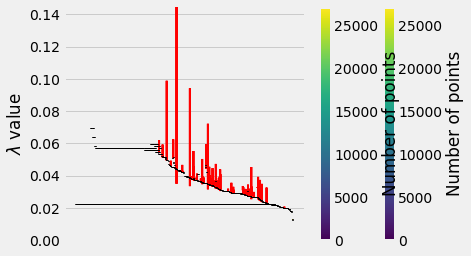

In [141]:
start = time.time()
print("Condensing the linkage tree and then plotting...")
#hdbscanner.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
hdbscanner.condensed_tree_.plot()
hdbscanner.condensed_tree_.plot(select_clusters=True)
print("...plotted condensed tree in {} seconds.".format(time.time()-start))
tree = hdbscanner.condensed_tree_
print("Found {} clusters".format(len(tree._select_clusters())))


### This can only be graphed as single linkage tree for very small datasets 

start = time.time()
print("Plotting single linkage tree (not for large data) ...")
hdbscanner.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
print("...plotted single linkage tree tree in {} seconds.".format(time.time()-start))

start = time.time()
print("Plotting condensed tree...")
hdbscanner.condensed_tree_.plot()
print("...plotted condensed tree in {} seconds.".format(time.time()-start))

Plotting condensed tree with vectors selected...
...plotted condensed tree with selected vectors in 3.870342969894409 seconds.


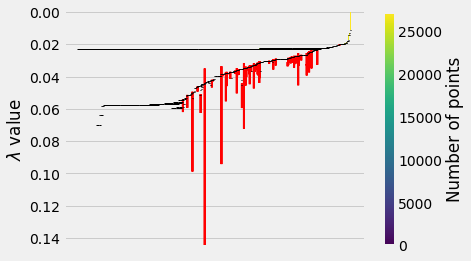

In [142]:
start = time.time()
print("Plotting condensed tree with vectors selected...")
hdbscanner.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
print("...plotted condensed tree with selected vectors in {} seconds.".format(time.time()-start))

In [143]:
def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
        points = raw_tree['child'][(raw_tree['parent'] == leaf) & 
                                   (raw_tree['lambda_val'] == max_lambda)]
        result = np.hstack((result, points))
    return result.astype(np.int)

# Harvesting Word Features
The below logic collects and filters word features from the condensed tree created in the cells above.

In [144]:
tree = hdbscanner.condensed_tree_

#print('Index, for reference:')
#for ind, entry in enumerate(index):
#    print("cluster: {}, ind: {}, entry: {}".format(hdbscanner.labels_[ind], ind, entry))

start = time.time()
print("Selecting clusters in tree...")
clusters = tree._select_clusters()
print("...finished selecting clusters in {} seconds.".format(time.time()-start))

initial_cluster_count = len(clusters)
print("Found {} clusters".format(initial_cluster_count))

selected_clusters = []

for i, c in enumerate(clusters):
    c_exemplars = exemplars(c, tree)
    
    #plt.scatter(data.T[0][c_exemplars], data.T[1][c_exemplars], c=palette[i], **plot_kwds)
    
    #print("Index: ", enumerate(index))
    #print("Output: ", output[:5])

    cluster_exemplars = set()
    for ind, ex_ind in enumerate(c_exemplars):
        #print("Exemplar -- {} : {}".format(index[ex_ind][0], index[ex_ind][2]))
        cluster_exemplars.add(index[ex_ind][2])
    
    members = set()
    for label_ind, label in np.ndenumerate(hdbscanner.labels_):
        if label == i:
            members.add(index[label_ind[0]][2])
            
            #print("Member: {} : {}".format(index[label_ind[0]][0], index[label_ind[0]][2]))
    
    exemplars_len = float(len(cluster_exemplars))
    members_len = float(len(members))
    
    if ((exemplars_len>0) and (len(members)>(2.0*exemplars_len))):
        #print("\nCluster {} persistence: {}".format(i, hdbscanner.cluster_persistence_.item(i)))
        #print("Cluster {} Exemplars: ".format(i),c_exemplars)
        #print("Cluster {} Exemplar Probabilities: ".format(i),[hdbscanner.probabilities_[ind] for ind in c_exemplars])
    
        example_cluster_exemplars = ", ".join(cluster_exemplars)
        example_cluster_members = ", ".join(members)
        
        selected_clusters.append([example_cluster_exemplars, example_cluster_members])

selected_cluster_count = len(selected_clusters)
if (selected_cluster_count>0):
    print("\nFound {} clusters ({}% of initially collected):".
          format(len(selected_clusters), 100.0*float(selected_cluster_count)/float(initial_cluster_count)))
    for example in selected_clusters:
        print("\nExemplars: {}".format(example[0]))
        print("Members: {}".format(example[1]))
                                                                    
noise_count = sum([1 for label in hdbscanner.labels_ if label == -1])
print("\nThere were {} words that were considered noise.".format(noise_count))

                                  
#print("\nOutliers.")
#for label_ind, label in np.ndenumerate(hdbscanner.labels_):
#    if label == -1:
#        print("{} : {}".format(index[label_ind[0]][0], index[label_ind[0]][2]))

Selecting clusters in tree...
...finished selecting clusters in 0.11753654479980469 seconds.
Found 322 clusters

Found 52 clusters (16.149068322981368% of initially collected):

Exemplars: christmas
Members: christmas, chistmas, xmas

Exemplars: car
Members: each car, car, truck, some car

Exemplars: dress, skirt
Members: clothes, her dress, dress, outfits, her skirt, dresses, skirt

Exemplars: design, designs
Members: its design, designs, these designs, design, designers

Exemplars: route, that route, one route
Members: route, that route, what routes, your routes, each route, their routes, road, routes, his routes, one route, which routes, three routes, your route

Exemplars: quest
Members: another quest, quest, every quest, that quest, each quest, one quest

Exemplars: toy
Members: another toy, toy, any toy, fun!this toy

Exemplars: pages, page
Members: some pages, their website, website, these pages, every page, pages, each page, page

Exemplars: group
Members: your group, group, ou

In [128]:
hdbscanner.labels_


array([ 23, 125,  -1, ...,  39,  53,  39])

In [129]:
print(c_exemplars[0])

7394


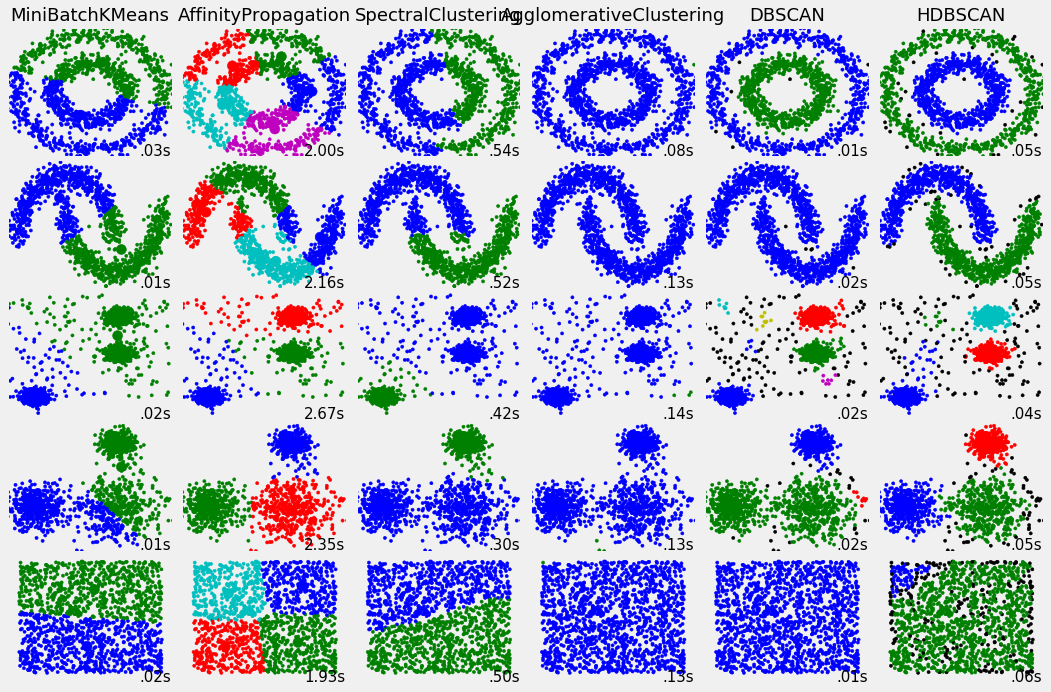

In [24]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

import hdbscan

np.random.seed(0)
plt.style.use('fivethirtyeight')

def make_var_density_blobs(n_samples=750, centers=[[0,0]], cluster_std=[0.5], random_state=0):
    samples_per_blob = n_samples // len(centers)
    blobs = [datasets.make_blobs(n_samples=samples_per_blob, centers=[c], cluster_std=cluster_std[i])[0]
             for i, c in enumerate(centers)]
    labels = [i * np.ones(samples_per_blob) for i in range(len(centers))]
    return np.vstack(blobs), np.hstack(labels)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.08)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.10)
blobs = datasets.make_blobs(n_samples=n_samples-200, random_state=8)
noisy_blobs = np.vstack((blobs[0], 25.0*np.random.rand(200, 2)-[10.0,10.0])), np.hstack((blobs[1], -1*np.ones(200))) 
varying_blobs = make_var_density_blobs(n_samples,
                                       centers=[[1, 1],
                                                [-1, -1],
                                                [1, -1]],
                                       cluster_std=[0.2, 0.35, 0.5])
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation',
    'SpectralClustering', 'AgglomerativeClustering',
    'DBSCAN', 'HDBSCAN']

plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

datasets = [noisy_circles, noisy_moons, noisy_blobs, varying_blobs, no_structure]
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    two_means = cluster.MiniBatchKMeans(n_clusters=2)
    spectral = cluster.SpectralClustering(n_clusters=2,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=2,
        connectivity=connectivity)

    #hdbscanner = hdbscan.HDBSCAN()
    clustering_algorithms = [
        two_means, affinity_propagation, spectral, average_linkage,
        dbscan, hdbscanner]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(5, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

In [25]:
import tensorflow as tf

# value = np.array(value)
# value = value.reshape([2, 4])
output_init = tf.constant_initializer(output)

print('fitting shape:')
tf.reset_default_graph()
with tf.Session() :
    embedding_var = tf.get_variable('x', shape = [len(output), len(output[0])], initializer = output_init)
    embedding_var.initializer.run()
    print(embedding_var.eval())
    
sess = tf.Session()

sess.run(embedding_init, feed_dict={embedding_var: embedding_var)})

path_for_metadata = './graphs/embedding_test/embedding_test.ckpt'

with open(path_for_metadata,'w') as f:
    f.write("Index\tLabel\n")
    for ind,label_line in enumerate(index):
        label = '{}:{}:{}'.format(label_line[0], label_line[1], label_line[2])
        f.write("%d\t%s\n" % (ind,label))

SyntaxError: invalid syntax (<ipython-input-25-22297b68dbff>, line 16)

In [ ]:
from tensorflow.contrib.tensorboard.plugins import projector

with tf.Session() as sess:
    # Create summary writer.
    writer = tf.summary.FileWriter('./graphs/embedding_test', sess.graph)
    # Initialize embedding_var
    #sess.run(embedding_var.initializer)
    sess.run(embedding_init, feed_dict={embedding_var: embedding_var})
    # Create Projector config
    config = projector.ProjectorConfig()
    # Add embedding visualizer
    embedding = config.embeddings.add()
    # Attache the name 'embedding'
    embedding.tensor_name = embedding_var.name
    # Metafile which is described later
    embedding.metadata_path = path_for_metadata
    # Add writer and config to Projector
    projector.visualize_embeddings(writer, config)
    # Save the model
    saver_embed = tf.train.Saver([embedding_var])
    saver_embed.save(sess, './graphs/embedding_test/embedding_test.ckpt', 1)

writer.close()